# Multimodal Search on the Amazon Products Dataset

[Alex Klibisz](https://alexklibisz.com)  
November 12, 2020 

## Introduction

This tutorial will demonstrate how to implement multimodal search on an e-commerce dataset using native Elasticsearch functionality, as well as features only available in the Elastiknn plugin.

We'll work with data from the [_Amazon Products Dataset_](http://jmcauley.ucsd.edu/data/amazon/links.html), which contains product metadata, reviews, and image vectors for 9.4 million Amazon products. We'll focus specifically on the _clothing, shoes, and jewelry_ category, containing about 1.5 million products. This dataset was collected by researchers at UCSD. The image vectors were computed using a convolutional neural network. For more information, see the paper _Justifying recommendations using distantly-labeled reviews and fine-grained aspects_ by Jianmo Ni, Jiacheng Li, and Julian McAuley. 

To demonstrate multimodal search, we'll first search for products using keywords, then use nearest neighbors queries to find image vectors with high angular similarity (indicating similar appearance), and then combine the keyword and nearest-neighbor searches.

The tutorial is implemented using a Jupyter notebook. The source can be found in the `examples` directory in the [Elastiknn github project.](https://github.com/alexklibisz/elastiknn)

---

**Caveats**

1. This tutorial assumes you are comfortable with Python, the Elasticsearch JSON API, and nearest neighbor search. To modify and run it on your own, you'll need to [install Elastiknn](https://elastiknn.com/installation/).
2. The purpose of this tutorial is not to offer a direct performance comparison. The query times are displayed, but they can vary pretty wildly across runs. The JVM is a tricky beast and any performance comparisons require many more samples. See the [Elastiknn performance docs](https://elastiknn.com/performance/) for more details.
3. The purpose of this tutorial is also not necessarily to convince you that I've improved the search results by using image vectors. That's a larger problem that would, at the very least, require investigating how the vectors were computed. Rather, the purpose is to show the mechanics and patterns of integrating traditional keyword search with nearest neighbor search on a dataset of non-trivial size.  


---
## Download the Data

Download two files:

1. meta_Home_and_Kitchen.json.gz - contains the product metadata, about 270mb.
2. image_features_Home_and_Kitchen.b - contains the 4096-dimensional image vectors, about 23gb.

In [1]:
fname_products = "meta_Tools_and_Home_Improvement.json.gz"
fname_vectors = "image_features_Tools_and_Home_Improvement.b"


In [2]:

!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/{fname_products}
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/image_features/categoryFiles/{fname_vectors}


File ‘meta_Tools_and_Home_Improvement.json.gz’ already there; not retrieving.

File ‘image_features_Tools_and_Home_Improvement.b’ already there; not retrieving.



In [3]:
!du -hs meta_Tools_and_Home_Improvement.json.gz
!du -hs image_features_Tools_and_Home_Improvement.b

 92M	meta_Tools_and_Home_Improvement.json.gz
4.1G	image_features_Tools_and_Home_Improvement.b


---
## Explore the Data

Let's have a look at the data. We'll first import some helpers from the `amazonutils` module and several other common libraries.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from amazonutils import *
from itertools import islice
from tqdm import tqdm
from pprint import pprint, pformat
from IPython.display import Image, display, Markdown, Code, HTML
import matplotlib.pyplot as plt
import numpy as np
import json

Now iterate over the metadata for a few products using the `iter_products` function. Each product is a dictionary containing a title, price, etc.

{'asin': '0980966043',
 'categories': [['Tools & Home Improvement',
                 'Power & Hand Tools',
                 'Power Tool Accessories',
                 'Woodworking Project Plans & Kits',
                 'Project Plans']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51AaoVEwseL._SY300_.jpg',
 'price': 9.03,
 'title': '&quot;Making Shaker Oval Boxes with Brent Rourke&quot; DVD by Rob '
          'Cosman'}


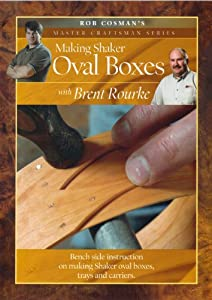

{'asin': '0980966078',
 'categories': [['Tools & Home Improvement',
                 'Power & Hand Tools',
                 'Power Tool Accessories',
                 'Woodworking Project Plans & Kits',
                 'Project Plans']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51cMn9WGkcL._SY300_.jpg',
 'price': 39.95,
 'title': 'Rob Cosman Hand-Cut Dovetails 2.0 DVD'}


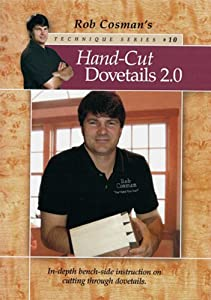

{'asin': '100100003X',
 'brand': 'Incredible Magnets',
 'categories': [['Tools & Home Improvement',
                 'Hardware',
                 'Cabinet Hardware',
                 'Catches']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51Ug0IrH1uL._SX300_.jpg',
 'price': 9.96,
 'title': 'MAGCREDIBLE&reg; Magnets - 1/2&quot; x 1/16&quot; Rare Earth Disc, '
          'Package of 24'}


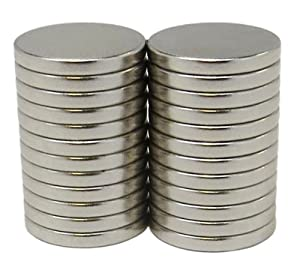

In [5]:
for p in islice(iter_products(fname_products), 5, 8):
  d = {k:v for (k,v) in p.items() if k not in {'related', 'description'}}
  pprint(d)
  display(Image(p['imUrl'], width=128, height=128))

Let's use the `iter_vectors` function to iterate over product IDs and image vectors. Each vector is just a list of 4096 floats, generated using a deep convolutional neural network. There is little value in inspecting the individual vectors, so we'll just show the vector length and first few values. 

In [6]:
for (asin, vec) in islice(iter_vectors(fname_vectors), 3):
  print(asin, len(vec), vec[:3])

1590651529 4096 [0.5455999970436096, 0.0, 0.0]
B000BVEG0S 4096 [0.0, 1.1363999843597412, 0.0]
B000G0F2CU 4096 [0.0, 0.2280000001192093, 0.0]


Let's sample a subset of vectors and plot the distribution of values. This will be more informative than inspecting individual vectors.

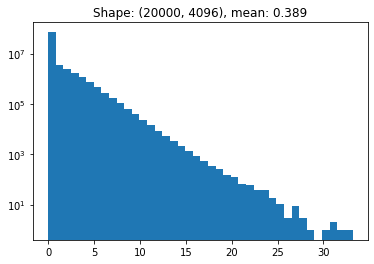

In [7]:
sample = np.array(
  [v for (_, v) in islice(iter_vectors(fname_vectors), 20000)]
)
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

### Reduce Vector Dimensionality

The histogram above shows there are many zeros in the vectors. 

The zeros usually don't add much information when computing similarity, but they do occupy storage space, memory, and CPU. We should be able to reduce the dimensionality while preserving most of the information. Forgive my mathematical hand-waviness in discussing "information."

Another reason for reducing dimensionality is that Elasticsearch's native `dense_vector` datatype only supports vectors up to 2048 dimensions.

I included a simple dimensionality reduction technique in the function `iter_vectors_reduced`. It takes the file name, the desired `dims`, and a number of `samples`. It iterates over the first `samples` vectors in the given file name, maintaining a sum along each index. It then finds the `dims` indices with the largest sums and returns another generator function which produces vectors from a given file name, returning only the greatest indices based on the original sample.

Reducing the dimensionality from 4096 to 256 produces close to an order of magnitude fewer zeros and preserves enough information for our purposes.

1590651529 256 [7.443299770355225, 2.3210999965667725, 3.635699987411499]
B000BVEG0S 256 [0.3560999929904938, 0.9139999747276306, 4.779600143432617]
B000G0F2CU 256 [5.131499767303467, 2.344399929046631, 0.0]


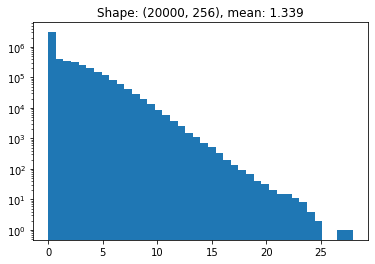

In [8]:
vector_dims = 256
reduced = iter_vectors_reduced(fname_vectors, dims=vector_dims, samples=10000)

for (asin, vec) in islice(reduced(fname_vectors), 3):
  print(asin, len(vec), vec[:3])

sample = np.array([v for (_, v) in islice(reduced(fname_vectors), 20000)])
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

In [12]:
#docker run -p 9201:9200 -p 9301:9300 -e "discovery.type=single-node" elastiknn-example:v7.10.2

---
## Connect to Elasticsearch

In [2]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

es = Elasticsearch(["http://localhost:9201"])
es.cluster.health(wait_for_status='yellow', request_timeout=1)

{'cluster_name': 'docker-cluster',
 'status': 'green',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'active_primary_shards': 1,
 'active_shards': 1,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 0,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 100.0}

---
## Create the Elasticsearch Index

To recap, each product in our dataset has a dictionary of metadata and a 256-dimensional image vector.

Let's create an index and define a mapping that represents this.
The mapping has these properties:

|property|type|description|
|:--|:--|:--|
|asin|keyword|Unique product identifier.|
|imVecElastiknn|elastiknn_dense_float_vector|The image vector, stored using Elastiknn. We'll also use the Angular LSH model to support approximate nearest neighbor queries.|
|imVecXpack|dense_vector|The image vector, stored using the X-Pack dense_vector data type.|
|title|text||
|description|text||
|price|float||

We're including two vectors: one using the `dense_vector` datatype that comes with Elasticsearch (specificially X-Pack), the other using the `elastiknn_dense_float_vector` datatype provided by Elastiknn.

I've chosen to use Angular similarity for finding similar vectors (i.e. similarly-looking products). I made this choice by experimenting with L2 and Angular similarity and seeing better results with Angular similarity. The similarity function that works best for your vectors has a lot to do with how the vectors were computed. In this case, I don't know a lot about how the vectors were computed, so a bit of guess-and-check was required.

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from amazonutils import *
from itertools import islice
from tqdm import tqdm
from pprint import pprint, pformat
from IPython.display import Image, display, Markdown, Code, HTML
import matplotlib.pyplot as plt
import numpy as np
import json

index = 'homeimprovementv2'
source_no_vecs = ['asin', 'title', 'description', 'price', 'imUrl']


In [5]:



settings = {
  "settings": {
    "elastiknn": True,
    "number_of_shards": 1,
    "number_of_replicas": 0
  }
}

mapping = {
  "dynamic": False,
  "properties": {
    "asin": { "type": "keyword" },
    "imVecElastiknn": {
      "type": "elastiknn_dense_float_vector",
      "elastiknn": {
        "dims": vector_dims,
        "model": "lsh",
        "similarity": "angular",
        "L": 60,
        "k": 3
      }
    },
    "imVecXpack": {
      "type": "dense_vector",
      "dims": vector_dims
    },
    "title": { "type": "text" },
    "description": { "type": "text" },
    "price": { "type": "float" },
    "imUrl": { "type": "text" }
  }
}


In [18]:

if not es.indices.exists(index):
  es.indices.create(index, settings)
  es.indices.put_mapping(mapping, index)
es.indices.get_mapping(index)

{'homeimprovementv2': {'mappings': {'dynamic': 'false',
   'properties': {'asin': {'type': 'keyword'},
    'description': {'type': 'text'},
    'imUrl': {'type': 'text'},
    'imVecElastiknn': {'type': 'elastiknn_dense_float_vector',
     'elastiknn': {'model': 'lsh',
      'similarity': 'angular',
      'dims': 256,
      'L': 60,
      'k': 3}},
    'imVecXpack': {'type': 'dense_vector', 'dims': 256},
    'price': {'type': 'float'},
    'title': {'type': 'text'}}}}}

# 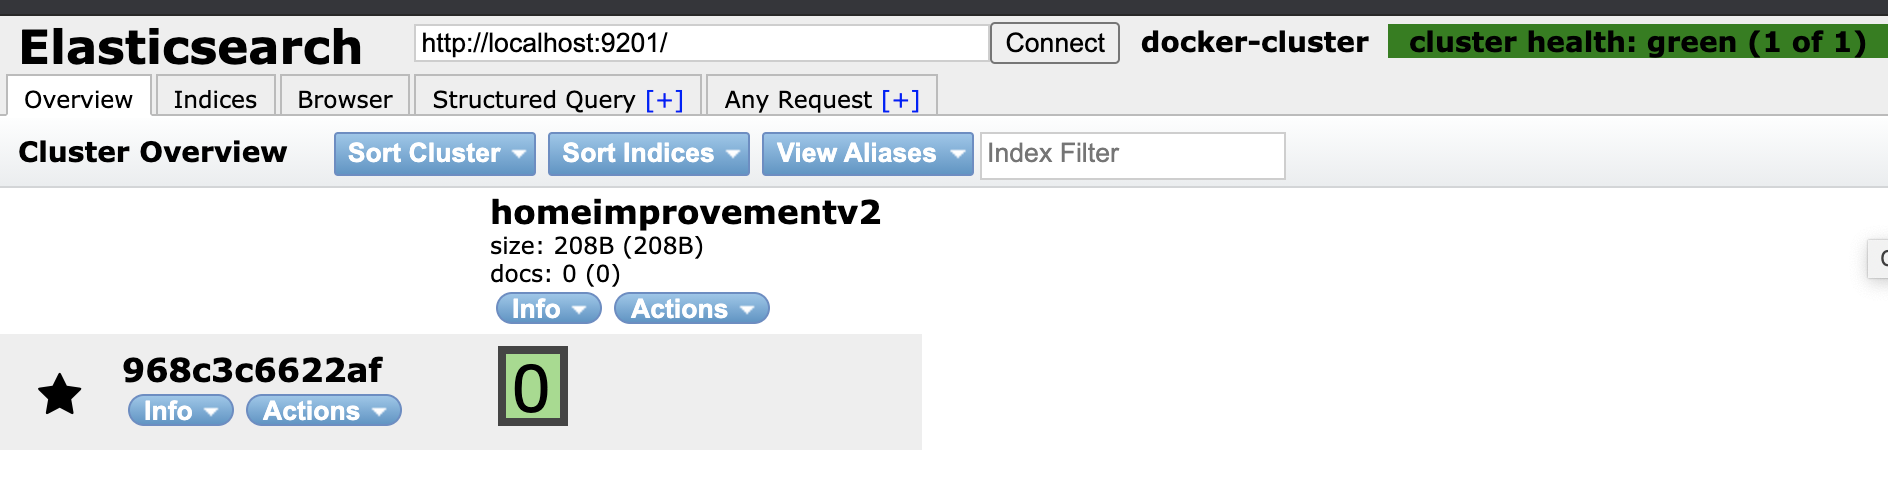

---

## Index the Products

Now that we've created a new index with an appropriate mapping, we can index (store) the products.

We'll first iterate over the product data, using the `asin` property as the document ID and storing everything except the vectors. Then we'll iterate over the vectors separately to add a vector to each doc.

We'll call `refresh` and `forcemerge` after the initial product indexing and after the vector updates. This moves all the docs into a single Lucene segment, which helps ensure you get roughly the same query results each time you re-build the index.

The product indexing takes about 5 minutes and vector indexing about 45 minutes on my laptop.

In [19]:
def product_actions():
  for p in tqdm(iter_products(fname_products)):
    yield { 
      "_op_type": "index", "_index": index, "_id": p["asin"], 
      "asin": p["asin"], "title": p.get("title", None), 
      "description": p.get("description", None),
      "price": p.get("price", None),
      "imUrl": p.get("imUrl", None)
    }

bulk(es, product_actions(), chunk_size=2000, max_retries=2)

269120it [01:13, 3684.27it/s]


(269120, [])

In [20]:
es.indices.refresh(index=index)
es.indices.forcemerge(index=index, max_num_segments=1, request_timeout=120)

{'_shards': {'total': 1, 'successful': 1, 'failed': 0}}

In [21]:
reduced = iter_vectors_reduced(fname_vectors, vector_dims, 10000)

def vector_actions():
  for (asin, v) in tqdm(reduced(fname_vectors)):
    yield { "_op_type": "update", "_index": index, "_id": asin, 
            "doc": { 
              "imVecElastiknn": { "values": v },
              "imVecXpack": v
            }}

bulk(es, vector_actions(), chunk_size=50, max_retries=10, request_timeout=60)

267141it [09:12, 483.90it/s]


(267141, [])

In [22]:
es.indices.refresh(index=index)
es.indices.forcemerge(index=index, max_num_segments=1, request_timeout=300)

{'_shards': {'total': 1, 'successful': 1, 'failed': 0}}

# 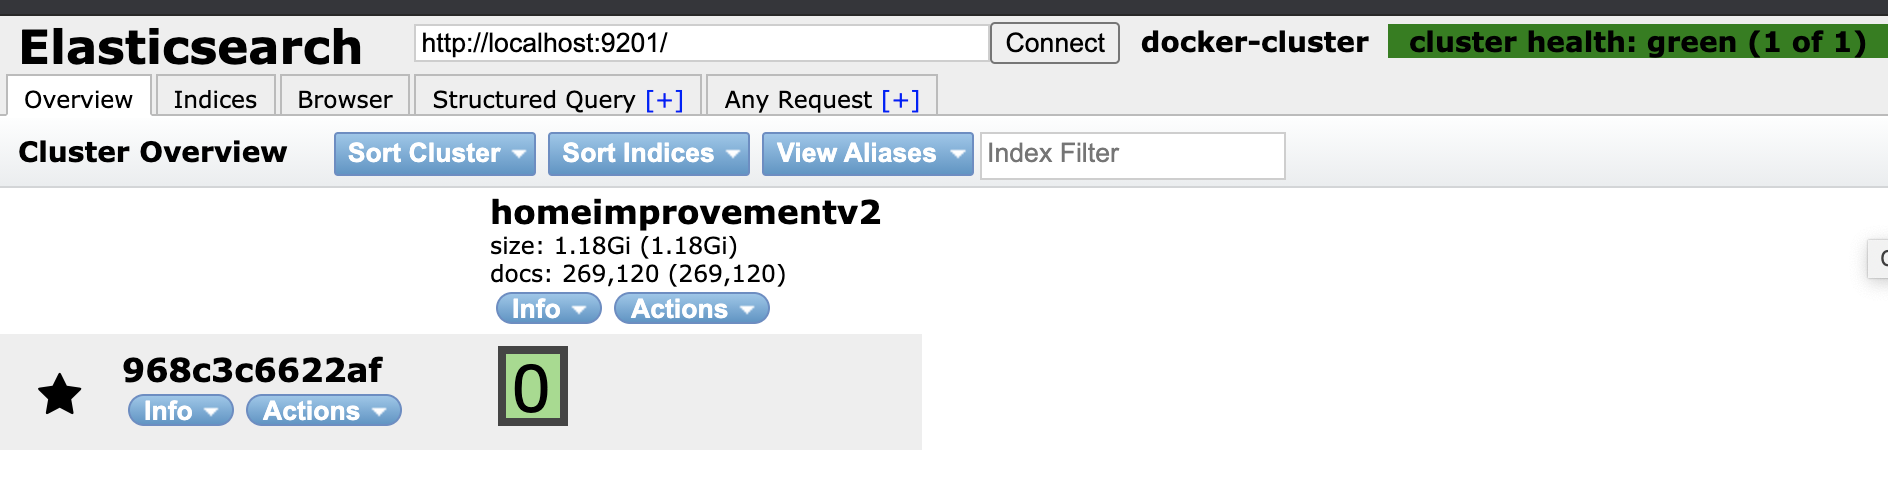

---

## Start searching with a keyword query

Imagine you're shopping for a men's wrist watch on Amazon.

You'll start by matching a simple keyword query, _**men's watch**_, against the title and description.

Found 10000 hits in 36 ms. Showing top 5.

Title   ECOBulb CFL Spiral Bulb
Desc    BPESL25TA Features: -Spiral bulb.-Energy star rating.-Carded.-Lifetime hours: 80...
Price   6.11
ID      B000I18WIS
Score   25.06675


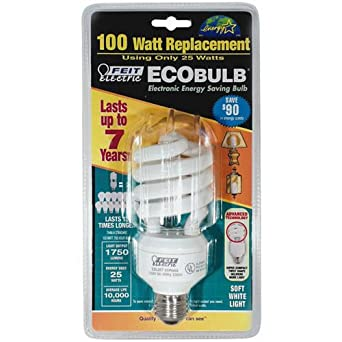


Title   Feit 18W CFL Spiral Light Bulb
Desc    The non-dimmable Feit 18W CFL Spiral Light Bulb produces an energy saving glow t...
Price   3.49
ID      B000I17GAI
Score   22.855547


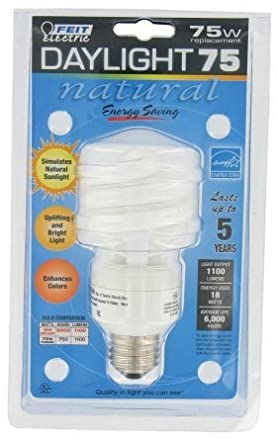


Title   BULB CFL SPIRAL 13W BUG [Misc.]
Desc    "EARTHBULB" YELLOW CFL BUG
LIGHT
*13 watt
*Mini spiral
*Medium base
*10,000 hour...
Price   9.7
ID      B0027JJR2Y
Score   22.855547


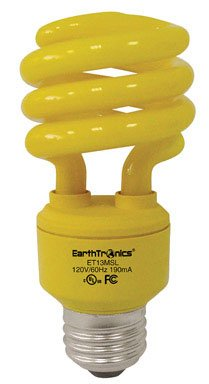


Title   Indoor Sunshine: Single 25-watt Spiral Bulb
Desc    Full spectrum compact fluorescent light (CFL).
Price   18.75
ID      B001KYU5MI
Score   21.890057


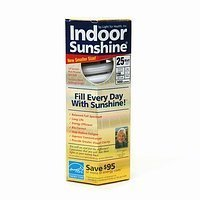


Title   Seagull Lighting 97040 PLS13 Spiral Fluorescent Bulb
Desc    Seagull 97040 Light Bulbs PLS13 Spiral Fluorescent Bulb
Price   6.39
ID      B0038XU1G4
Score   21.890057


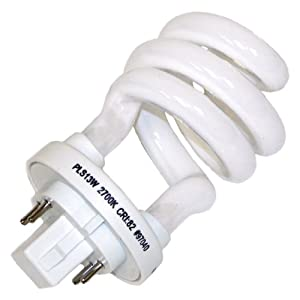

In [7]:


index = 'homeimprovementv2'
source_no_vecs = ['asin', 'title', 'description', 'price', 'imUrl']
vector_dims = 256

body = {
  "query": {
    "multi_match": {
      "query": "Spiral bulb",
      "fields": ["title^2", "description"]
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Find similar-looking products using native Elasticsearch vector functionality

You really like the top result (ID `B004N43FEM`) and want to explore some similar-looking options.

We'll start by using native Elasticsearch functionality to do an exact nearest neighbors query. This compares a given vector against all vectors in the index.

This query consists of three steps:

1. Fetch the image vector for your favorite product.
2. Use the vector in a script-score query that computes the `cosineSimilarity` between the vector and a stored vector.
3. Execute the query. 

Note that the top result is the original product. You would typically filter this out in your application logic.

In [21]:
product_id = "B0027JJR2Y"

fetch_res = es.get(index=index, id=product_id)
query_vec = fetch_res['_source']['imVecElastiknn']['values']


Found 10000 hits in 193 ms. Showing top 5.

Title   BULB CFL SPIRAL 13W BUG [Misc.]
Desc    "EARTHBULB" YELLOW CFL BUG
LIGHT
*13 watt
*Mini spiral
*Medium base
*10,000 hour...
Price   9.7
ID      B0027JJR2Y
Score   2.0


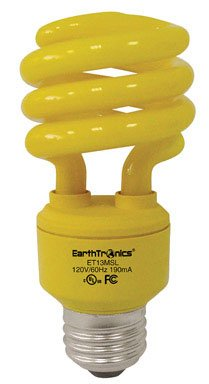


Title   EarthTronics CF13BG1B 13-Watt Spiral Compact T3 Florescent Light Bulb, Bug Yellow, 12-Pack
Desc    None
Price   50.27
ID      B004WQP7NS
Score   1.9556966


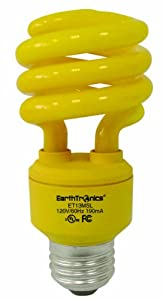


Title   13 Watt - 60 W Equal - Green Party Light - EarthBulb by EarthTronics CF13GR1B
Desc    "EARTHBULB" GREEN PARTY BULB

 * 13 watt
 * Mini spiral
 * 10,000 hours
 * Mediu...
Price   4.93
ID      B0025V5FRA
Score   1.8428285


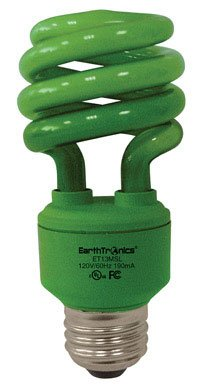


Title   Earthbulb Red Cfl Party Bulb
Desc    Your choice of lighting in your home matters. Lighting represents a significant ...
Price   7.24
ID      B0025M54T8
Score   1.8054509


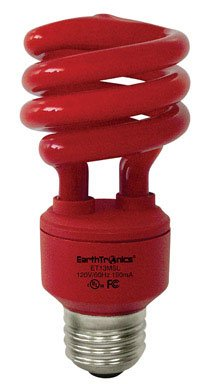


Title   Goodlite G-10845 18-Watt CFL 75 Watt Replacement 1250-Lumen T2 Spiral Light Bulb , Super Long 12,000 hour life (10.9 Years) 25-Pack
Desc    Compact Florescent Light Bulb (CFL) offers long life and quality energy efficien...
Price   93.75
ID      B00AUZH800
Score   1.7719258


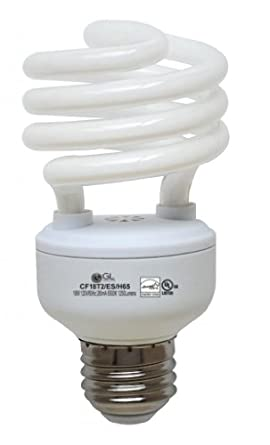

In [22]:

body = {
  "query": {
    "script_score": {
      "query": { "match_all": {} },
      "script": {
        # If the `imVecXpack` vector is missing, just return 0. Else compute the similarity.
        "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
        "params": {
          "vec": query_vec
        }
      }
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Find similar-looking products using Elastiknn's exact nearest neighbors query

Let's implement the same nearest_neighbors query using Elastiknn. You'll notice two differences compared to the previous query:

1. We reference the query vector using its document ID and the field containing the vector. This avoids a round trip request to fetch the vector.
2. We don't need to use a script. The whole query is simple JSON keys and values.

Note the results are identical to the native Elasticsearch query.

Found 10000 hits in 5083 ms. Showing top 5.

Title   BULB CFL SPIRAL 13W BUG [Misc.]
Desc    "EARTHBULB" YELLOW CFL BUG
LIGHT
*13 watt
*Mini spiral
*Medium base
*10,000 hour...
Price   9.7
ID      B0027JJR2Y
Score   2.0


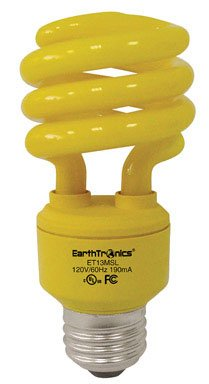


Title   EarthTronics CF13BG1B 13-Watt Spiral Compact T3 Florescent Light Bulb, Bug Yellow, 12-Pack
Desc    None
Price   50.27
ID      B004WQP7NS
Score   1.9556966


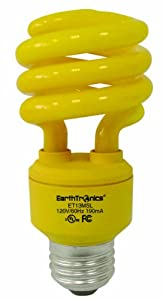


Title   13 Watt - 60 W Equal - Green Party Light - EarthBulb by EarthTronics CF13GR1B
Desc    "EARTHBULB" GREEN PARTY BULB

 * 13 watt
 * Mini spiral
 * 10,000 hours
 * Mediu...
Price   4.93
ID      B0025V5FRA
Score   1.8428284


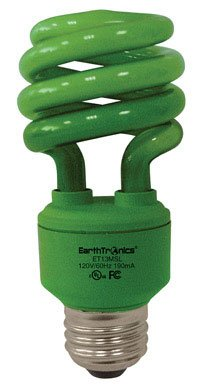


Title   Earthbulb Red Cfl Party Bulb
Desc    Your choice of lighting in your home matters. Lighting represents a significant ...
Price   7.24
ID      B0025M54T8
Score   1.8054509


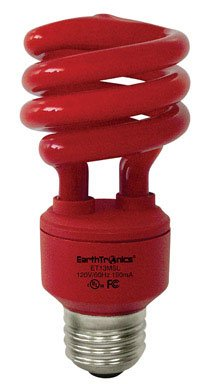


Title   Goodlite G-10845 18-Watt CFL 75 Watt Replacement 1250-Lumen T2 Spiral Light Bulb , Super Long 12,000 hour life (10.9 Years) 25-Pack
Desc    Compact Florescent Light Bulb (CFL) offers long life and quality energy efficien...
Price   93.75
ID      B00AUZH800
Score   1.7719258


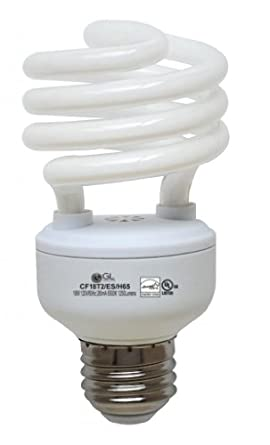

In [9]:
body = {
  "query": {
    "elastiknn_nearest_neighbors": {
      "vec": {
        "index": index,
        "id": product_id,
        "field": "imVecElastiknn"
      },
      "field": "imVecElastiknn",
      "model": "exact",
      "similarity": "angular"
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Find similar-looking products (faster) using Elastiknn's approximate query

Both of the previous queries take > 500ms. Each query scores _every_ vector in the index, so the runtime only increases as the index grows.

To address this, Elastiknn offers approximate nearest neighbors queries based on the [Locality Sensitive Hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) technique. 

We used the angular LSH model (i.e. `"model": "lsh", "similarity": "angular"`) when defining the mapping (right before indexing the data). Now we can use the same model and similarity to run an approximate nearest neighbors query. This query takes a `"candidates"` parameter, which is the number of approximate matches that will be re-ranked using the exact similarity score.

Using the approximate query with 100 candidates yields reasonable results in under 150 ms. 

You can tweak the mapping and query parameters to fine-tune the speed/recall tradeoff. The [API docs](https://elastiknn.com/api/) include notes on how the parameters generally affect speed/recall, and the [Performance docs](https://elastiknn.com/performance/) include suggested parameter settings for several datasets.

Found 100 hits in 308 ms. Showing top 5.

Title   BULB CFL SPIRAL 13W BUG [Misc.]
Desc    "EARTHBULB" YELLOW CFL BUG
LIGHT
*13 watt
*Mini spiral
*Medium base
*10,000 hour...
Price   9.7
ID      B0027JJR2Y
Score   2.0


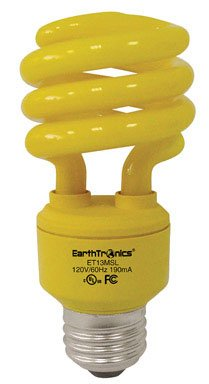


Title   EarthTronics CF13BG1B 13-Watt Spiral Compact T3 Florescent Light Bulb, Bug Yellow, 12-Pack
Desc    None
Price   50.27
ID      B004WQP7NS
Score   1.9556966


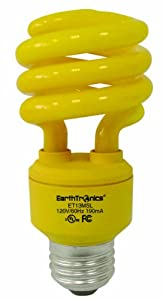


Title   13 Watt - 60 W Equal - Green Party Light - EarthBulb by EarthTronics CF13GR1B
Desc    "EARTHBULB" GREEN PARTY BULB

 * 13 watt
 * Mini spiral
 * 10,000 hours
 * Mediu...
Price   4.93
ID      B0025V5FRA
Score   1.8428284


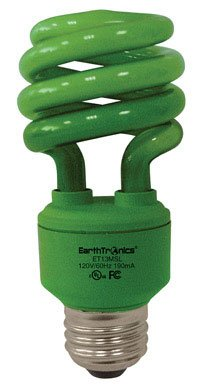


Title   Goodlite G-10845 18-Watt CFL 75 Watt Replacement 1250-Lumen T2 Spiral Light Bulb , Super Long 12,000 hour life (10.9 Years) 25-Pack
Desc    Compact Florescent Light Bulb (CFL) offers long life and quality energy efficien...
Price   93.75
ID      B00AUZH800
Score   1.7719258


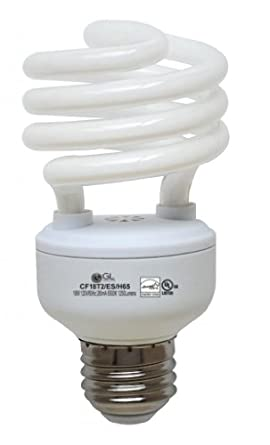


Title   Goodlite G-10844 18-Watt CFL 75 Watt Replacement 1250-Lumen T2 Spiral Light Bulb , Super Long 12,000 hour life (10.9 Years) Warm white 2700k
Desc    Compact Florescent Light Bulb (CFL) offers long life and quality energy efficien...
Price   None
ID      B00BC6E6DI
Score   1.7719258


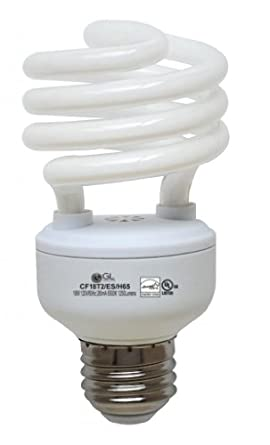

In [10]:
body = {
  "query": {
    "elastiknn_nearest_neighbors": {
      "vec": {
        "index": index,
        "field": "imVecElastiknn",
        "id": product_id
      },
      "field": "imVecElastiknn",
      "model": "lsh",
      "similarity": "angular",
      "candidates": 100
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Combine keyword and nearest neighbors queries using native Elasticsearch

The previous queries returned some nice results, but you decide you really want this watch to be blue.

To support this, we can combine a keyword query for "blue" with a nearest neighbors query for the original image vector.

Native Elasticsearch lets us do this by modifying the `query` clause in the `script_score` query.

Found 8670 hits in 50 ms. Showing top 5.

Title   Earthbulb Red Cfl Party Bulb
Desc    Your choice of lighting in your home matters. Lighting represents a significant ...
Price   7.24
ID      B0025M54T8
Score   1.8054509


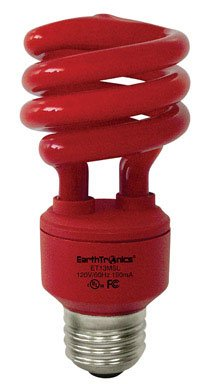


Title   Globe Electric 0016101 60-Watt Equivalent 13-Watt EnerSaver CFL Party Bulb, Red
Desc    This party compact fluorescent light bulb glows Red and it is great for events a...
Price   4.98
ID      B0061YO7B2
Score   1.6927202


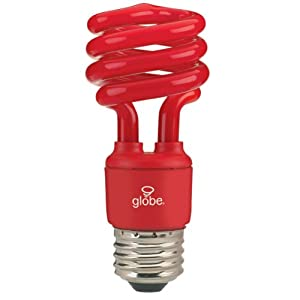


Title   Poly Hose Nozzle (Fog/Stream/Shut-Off), 1 1&frasl;2&quot; NST, 78 gpm
Desc    Polycarbonate Fire Hose Nozzles offer two advantages over brass versionsthey are...
Price   None
ID      B00B79Q3WC
Score   1.6508645


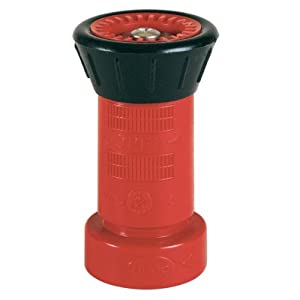


Title   Sunlite SL24/R 24 Watt Spiral Energy Saving CFL Light Bulb Medium Base Red
Desc    Sunlite Colored Spiral Compact Fluorescent lamps are ultra compact, fit into mos...
Price   7.42
ID      B002P4MAXE
Score   1.6462554


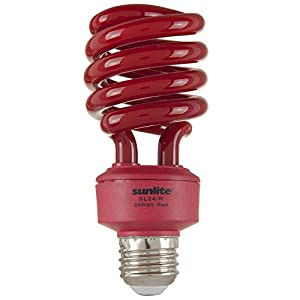


Title   Feit Electric ESL13T/R 13-Watt Compact Fluorescent Mini Twist Bulb (60-Watt Incandescent Equivalent), Red
Desc    13-Watt - Compact Fluorescent Mini Twist Red Lamp - Save energy and money by rep...
Price   4.98
ID      B000LWIQ08
Score   1.6437074


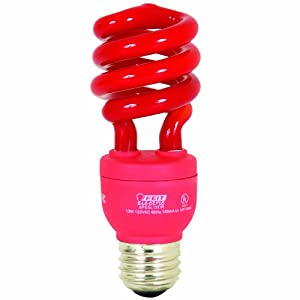

In [11]:
body = {
  "query": {
    "script_score": {
      "query": {
        "multi_match": {
          "query": "red",
          "fields": ["title^2", "description"]
        }
      },
      "script": {
        "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
        "params": {
          "vec": query_vec
        }
      }
    }
  }
}
res = es.search(index=index, body=body, size=5)
display_hits(res)

---
## Combine keyword and nearest neighbors queries using Elastiknn's exact query

We can do the same thing using a function score query containing an `elastiknn_nearest_neighbors` function. This function takes the exact same parameters as an `elastiknn_nearest_neighbors` query.

Note that the function score query gives you quite a bit more flexibility. Specifically, you can tweak the `boost_mode` parameter to control how the keyword and nearest neighbor queries are combined and tweak the `weight` to scale the nearest neighbor query score.

There are still some caveats, which are covered in the [API docs](https://elastiknn.com/api/#using-a-function-score-query).

Found 8058 hits in 91 ms. Showing top 5.

Title   13 Watt - 60 W Equal - Blue Party Light - CFL Light Bulb - Earthbulb by EarthTronics CF13BL1B
Desc    None
Price   None
ID      B0027JLPHY
Score   3.441374


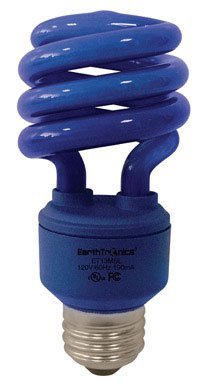


Title   Sunlite SL24/B 24 Watt Spiral Energy Saving CFL Light Bulb Medium Base Blue
Desc    Sunlite Colored Spiral Compact Fluorescent lamps are ultra compact, fit into mos...
Price   9.99
ID      B002P4NRUE
Score   3.366592


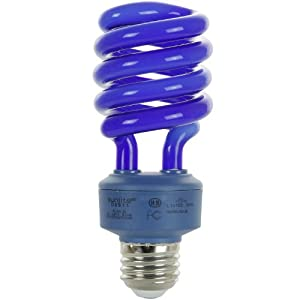


Title   Feit Electric ESL13T/B 13-Watt Compact Fluorescent Mini Twist Bulb (60-Watt Incandescent Equivalent), Blue
Desc    13-Watt - Compact Fluorescent Mini Twist Blue Lamp - Save energy and money by re...
Price   5.99
ID      B000LWMSBQ
Score   3.3648717


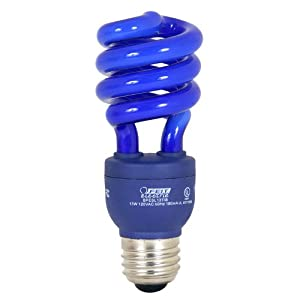


Title   Feit Electric BPESL15T/BLB 13-Watt Compact Fluorescent Twist Bulb (60-Watt Incandescent Equivalent), Black Light Blue
Desc    13 Watt - Compact Fluorescent Twist Blacklight Lamp - Save energy and money by r...
Price   4.88
ID      B000I1AE20
Score   3.3072166


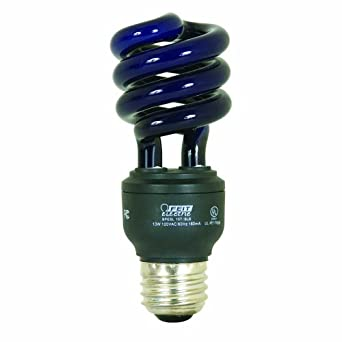


Title   Bulbrite H50PAR20B50W 120V PAR20 Halogen Light, Blue
Desc    50-Watt halogen par 20 blue, medium (e26) base, 120V.
Price   8.35
ID      B000YL5HEO
Score   3.261369


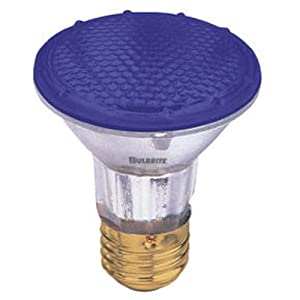

In [12]:
body = {
  "query": {
    "function_score": {
      "query": {
        "bool": {
          "filter": {
            "exists": {
              "field": "imVecElastiknn"
            }
          },
          "must": {
            "multi_match": {
              "query": "blue",
              "fields": ["title^2", "description"]
            }
          }
        }
      },
      "boost_mode": "replace",
      "functions": [{
        "elastiknn_nearest_neighbors": {
          "field": "imVecElastiknn",
          "similarity": "angular",
          "model": "exact",
          "vec": {
            "values": query_vec
          }
        },
        "weight": 2
      }]
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Combine keyword and nearest neighbors queries using Elastiknn's approximate query

The term "blue" occurs very frequently in a catalog of clothing, shoes, and jewelry. The queries above matched 10k docs for the term, and then evaluated exact nearest neighbors on those docs. In most cases, including this one, the exact query will be sufficiently fast when combined with a filter. If you encounter a case where that's not true, you can experiment with an approxiamte query, demonstrated below. The results won't always be faster, as there's some overhead in computing and matching hashes.

Found 4283 hits in 31 ms. Showing top 5.

Title   BULB CFL SPIRAL 13W BUG [Misc.]
Desc    "EARTHBULB" YELLOW CFL BUG
LIGHT
*13 watt
*Mini spiral
*Medium base
*10,000 hour...
Price   9.7
ID      B0027JJR2Y
Score   2.9333334


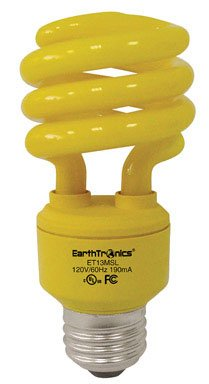


Title   EarthTronics CF13BG1B 13-Watt Spiral Compact T3 Florescent Light Bulb, Bug Yellow, 12-Pack
Desc    None
Price   50.27
ID      B004WQP7NS
Score   2.5333333


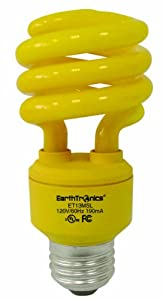


Title   Goodlite G-10845 18-Watt CFL 75 Watt Replacement 1250-Lumen T2 Spiral Light Bulb , Super Long 12,000 hour life (10.9 Years) 25-Pack
Desc    Compact Florescent Light Bulb (CFL) offers long life and quality energy efficien...
Price   93.75
ID      B00AUZH800
Score   1.8


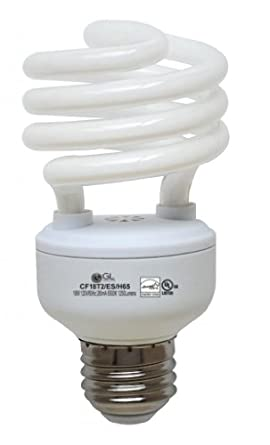


Title   Goodlite G-10844 18-Watt CFL 75 Watt Replacement 1250-Lumen T2 Spiral Light Bulb , Super Long 12,000 hour life (10.9 Years) Warm white 2700k
Desc    Compact Florescent Light Bulb (CFL) offers long life and quality energy efficien...
Price   None
ID      B00BC6E6DI
Score   1.8


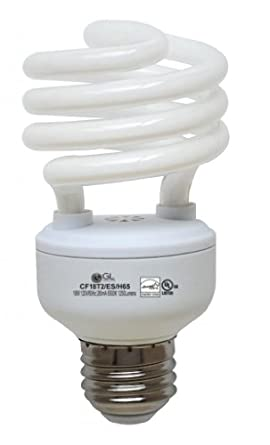


Title   LASCO 10-1201 12-Inch Long Flexible Gas Dryer Connector Line with 3/8-Inch Diameter with 1/2-Inch Fittings
Desc    LASCO 10-1201 Flexible Gas Dryer Connector Line, 3/8-Inch Diameter with 1/2-Inch...
Price   17.41
ID      B0083GC56A
Score   1.7333333


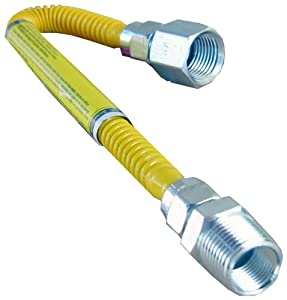

In [25]:
body = {
  "query": {
    "function_score": {
      "query": {
        "bool": {
          "filter": {
            "exists": {
              "field": "imVecElastiknn"
            }
          },
          "must": {
            "multi_match": {
              "query": "yellow",
              "fields": ["title^2", "description"]
            }
          }
        }
      },
      "boost_mode": "replace",
      "functions": [{
        "elastiknn_nearest_neighbors": {
          "field": "imVecElastiknn",
          "similarity": "angular",
          "L": 0,                            # 5
          "k": 2,  
          "model": "lsh",
          "candidates": 10,
          "vec": {
            "values": query_vec
          }
        },
        "weight": 2
      }]
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)
